## 1. Cargar Datos  MLP

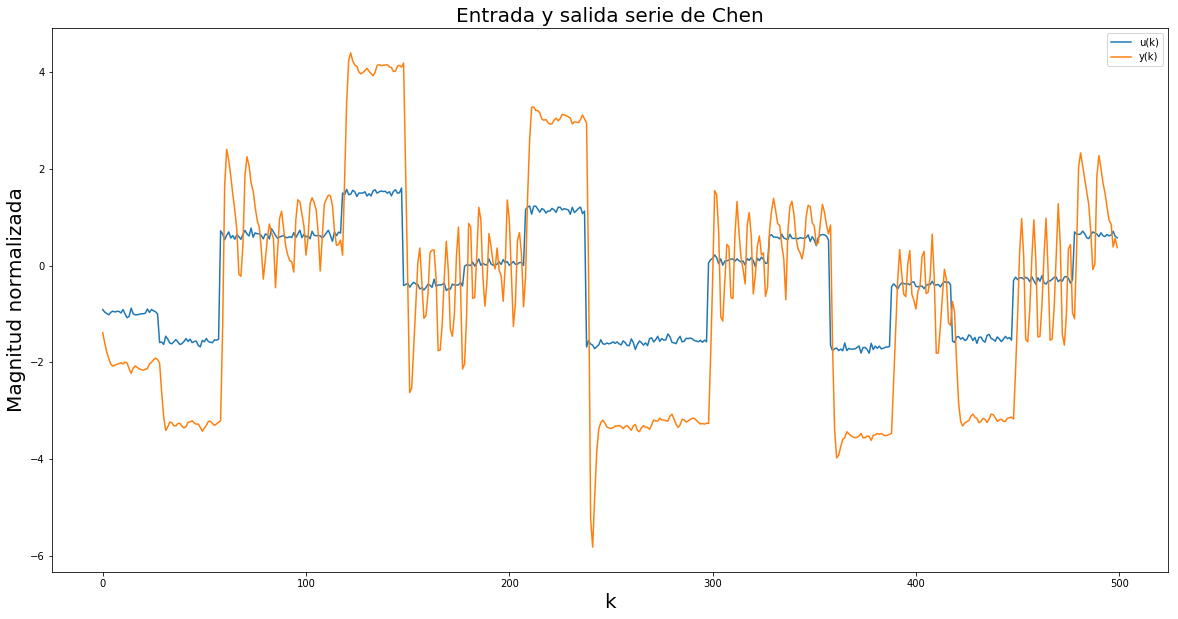

In [2]:
#######                     IMPORTAR LIBRERIAS                                          #######
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)



dataframe = pd.read_csv("datos.csv", header=None, delimiter = ';')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.55)
test_size = int(len(dataset)*0.25)

train, test, val = dataset[0:train_size,:], dataset[train_size:(train_size+test_size),:], dataset[(train_size+test_size):len(dataset),:]


######

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# u(t) es la primera columna de train
# y(t) es la segunda columna de train 

u_train = np.reshape(train[:,0],(-1,1))
u_test = np.reshape(test[:,0],(-1,1))
u_val =  np.reshape(val[:,0],(-1,1))
y_train = np.reshape(train[:,1],(-1,1))
y_test = np.reshape(test[:,1],(-1,1))
y_val = np.reshape(val[:,1],(-1,1))

plt.figure(figsize=(20,10))
plt.plot(u_train[0:500]) 
plt.plot(y_train[0:500])

plt.xlabel('k',fontsize = 20)
plt.ylabel('Magnitud normalizada',fontsize = 20)
plt.title('Entrada y salida serie de Chen',fontsize = 20)
plt.legend(('u(k)','y(k)'), loc = 'upper right')
plt.show()



u_min = np.amin(u_train)
u_max = np.amax(u_train)

y_min = np.amin(y_train)
y_max = np.amax(y_train)

#normalizar

u_train = (u_train-u_min)/(u_max-u_min)
y_train = (y_train-y_min)/(y_max-y_min)
u_test = (u_test-u_min)/(u_max-u_min)
u_val = (u_val-u_min)/(u_max-u_min)
y_test = (y_test-y_min)/(y_max-y_min)
y_val = (y_val-y_min)/(y_max-y_min)


# ENTRENAMIENTO
x_train = np.concatenate((u_train, y_train), axis=1) 
x_train_1 = np.array(series_to_supervised(x_train, n_in=3, n_out=1))[:,0:6]
y_train_1 = np.array(series_to_supervised(x_train, n_in=3, n_out=1))[:,7]






# TEST 

x_test= np.concatenate((u_test, y_test), axis=1) 
x_test_1 = np.array(series_to_supervised(x_test, n_in=3, n_out=1))[:,0:6]
y_test_1 = np.array(series_to_supervised(x_test, n_in=3, n_out=1))[:,7]




# VALIDACION

x_val= np.concatenate((u_val, y_val), axis=1) 
x_val_1 = np.array(series_to_supervised(x_val, n_in=3, n_out=1))[:,0:6]
y_val_1 = np.array(series_to_supervised(x_val, n_in=3, n_out=1))[:,7]


x_train_MLP = x_train_1
y_train_MLP = np.reshape(y_train_1,(-1,1))


x_test_MLP = x_test_1
y_test_MLP = np.reshape(y_test_1,(-1,1))


x_val_MLP = x_val_1
y_val_MLP = np.reshape(y_val_1,(-1,1))




# X: conjunto de entrenamiento [n_muestras,n_caracteristicas]
# y: conjunto objetivo [n_muestras,n_caracteristicas]
# batch_indice = numero del batch a generar. El numero de batch que se pueden
#                generar es m = (np.ceil(n_muestras / tamaño batch))
# batch_tamaño =  tamaño del batch a generar
def generar_mini_batch(X , y, batch_indice, batch_tamano):
    batch_indice = np.random()
    while True:
        
        inicio = batch_indice*batch_tamano
        fin = (batch_indice+1)*batch_tamano
        X_batch = X[inicio:fin,:]
        y_batch = y[inicio:fin,:]
        return X_batch, y_batch


# conjuntos

y_train_intervalo = np.concatenate((y_train_MLP,y_train_MLP,y_train_MLP),axis = 1)
y_test_intervalo = np.concatenate((y_test_MLP,y_test_MLP,y_test_MLP),axis = 1)
y_val_intervalo = np.concatenate((y_val_MLP,y_val_MLP,y_val_MLP),axis = 1)


## 2. Crear Grafo

In [37]:
import tensorflow as tf

#from datetime import datetime
#now = datetime.utcnow().strftime("funciona4")
#root_logdir = "tf_logs"
#logdir = "{}/run-{}/".format(root_logdir, now)
"""
Esta función construye un grafo
parametro ---> Penaliza en la funcion de costos aquellos valores fuera del intervalo

retorna los nodos del grafo que seran utilizados luego
"""

def red_neuronal(parametro):
    g = tf.Graph()
    with g.as_default():
        n_epochs = 2000
        learning_rate = 0.01

        n_entradas = 6
        n_neuronas = 20
        n_outputs = 3

        #lamb = 100

        #lamb = 0.2

        X = tf.placeholder(tf.float32, shape=(None,n_entradas), name = "X")
        y = tf.placeholder(tf.float32, shape =(None,3), name = "y")

        from tensorflow.contrib.layers import fully_connected

        with tf.name_scope("dnn"):
            hidden1 = fully_connected(X, n_neuronas, scope="hidden1")
            z1 = fully_connected(hidden1, n_outputs, scope="outputs",activation_fn=None)

        with tf.name_scope("error"):
            error = y - z1 



        with tf.name_scope("errores"):
            error_lower = error[:,0]
            error_crisp = error[:,1]
            error_upper = error[:,2]



        mse_lower = tf.reduce_mean(tf.square(error_lower), name="mse_lower")
        mse_crisp = tf.reduce_mean(tf.square(error_crisp), name="mse_crisp")
        mse_upper = tf.reduce_mean(tf.square(error_upper), name="mse_upper")

        mse_upper1= tf.reduce_mean(tf.square(tf.maximum(error_upper, 0., name="relu1")))
        mse_lower1= tf.reduce_mean(tf.square(tf.maximum(-error_lower, 0., name="relu2")))

        loss_upper = mse_upper + parametro*mse_upper1
        loss_lower = mse_lower + parametro*mse_lower1

        loss = mse_crisp + loss_upper + loss_lower




        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
    return g,X,y,z1,training_op,init,saver,loss


## 3. Métricas

In [38]:
def PINAW(intervalo_superior,intervalo_inferior,data):
    N = len(intervalo_superior)
    maximo = np.amax(data)
    minimo = np.amin(data)
    R = maximo - minimo
    op1 = np.subtract(intervalo_superior,intervalo_inferior) 
    op2 = (1/(N*R))*(np.sum(op1))
    return op2

def PICP(intervalo_superior,intervalo_inferior,data):
    N = len(intervalo_superior)
    contador = 0
    for i in range(0,len(data)):
        if intervalo_superior[i] > data[i] > intervalo_inferior[i]:
            contador +=1
    return contador/N 

In [39]:
## Calcular PINAW PICP
"""
Esta funcion permite calcular el valor del PINAW, PICP y RMSE de
las predicciones a n pasos.
x_val = datos [u(t),y(t)] con estos se forma la matriz de entrenamiento
y_max = maximo valor salida 
y_min = minimo valor de salida 
Estos son utilizados para desnormalizar las predicciones y calcular apropiadamente las metricas

z1 = Es el nodo de salida del grafo utilizado.
z1 contiene [y_lower,y_crisp,y_upper]



"""
def calcular_PINAW_PICP(n,x_val,y_max,y_min,z1):
    n_in = 3
    matriz_n_paso = np.array(series_to_supervised(x_val, n_in=3, n_out=n+1))
    matriz_n_paso = np.reshape(matriz_n_paso,((matriz_n_paso.shape[0]),n_in+(n+1),2))    
    for i in range(0,(n+1)):
        x = matriz_n_paso[:,0+i:n_in+i,:]
        x = np.reshape(x,(x.shape[0],n_in*2))
        prediccion_val = z1.eval(feed_dict={X: x})
        y_lower = prediccion_val[:,0]
        y_crisp = prediccion_val[:,1]
        y_upper = prediccion_val[:,2]        
        rmse = np.sqrt(mean_squared_error(y_crisp*(y_max-y_min)+y_min,
                                          matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min))
        A = PINAW(y_upper*(y_max-y_min)+y_min,y_lower*(y_max-y_min)+y_min,matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min)
        B = PICP(y_upper*(y_max-y_min)+y_min,y_lower*(y_max-y_min)+y_min,matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min)      
        matriz_n_paso[:,n_in+i,1]=y_crisp
        PINAW_percent = A*100
        PICP_percent = B*100
    return PINAW_percent,PICP_percent,rmse

## 4. Entrenamiento

In [ ]:
batch_size = 100
n_batches = int(np.ceil(x_train_MLP.shape[0] / batch_size))
best_PINAW = 0

for lam in range(300,800,20):
    g,X,y,z1,training_op,init,saver = red_neuronal(lam)
    
    with tf.Session(graph = g) as sess:
        sess.run(init)
        n_epochs = 2000
        print(lam)
        for epoch in range(n_epochs):               
            for batch_indice in range(n_batches):
                X_batch, y_batch = generar_mini_batch(x_train_MLP, y_train_intervalo, batch_indice, batch_size)                
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        PINAW_percent,PICP_percent = calcular_PINAW_PICP(1,x_test,y_max,y_min,z1)
        print('PINAW =',PINAW_percent,'PICP = ',PICP_percent)
    
        if PICP_percent > 90.0:
            print(lam)
            best_PINAW = PINAW_percent
            save_path = saver.save(sess, "./my_model_intervalo1.ckpt")
            parametro = lam
            print('El parametro es:',parametro)
            
            
            break

In [14]:
batch_size = 100
n_batches = int(np.ceil(x_train_MLP.shape[0] / batch_size))
n_epochs = 2000
perdida_test_vector = np.zeros(n_epochs)
perdida_train_vector = np.zeros(n_epochs)


# crear grafo

g,X,y,z1,training_op,init,saver,loss = red_neuronal(300)

with tf.Session(graph=g) as sess:
    sess.run(init)
    loss_minimo = 1000.0
    contador = 0
    for epoch in range(n_epochs):
        for batch_indice in range(n_batches):
            X_batch, y_batch = generar_mini_batch(x_train_MLP, y_train_intervalo, batch_indice, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        perdida = sess.run(loss, feed_dict={X: x_test_MLP, y: y_test_intervalo})
        perdida_train = sess.run(loss, feed_dict={X: x_train_MLP, y: y_train_intervalo})
        perdida_test_vector[epoch] = perdida
        perdida_train_vector[epoch] = perdida_train
        
        print('EPOCH: ',epoch,'LOSS_TEST: ',perdida)
        # early stopping
        if perdida < loss_minimo:
            loss_minimo = perdida
            save_path = saver.save(sess, "./mejor_modelo.ckpt")
            contador = 0 # reiniciar contador
            
            
        else:
            contador +=1
            if contador == 6:
                
                print('El entrenamiento ha sido detenido')
                #break 
                
        
            
            
            
            


EPOCH:  0 LOSS_TEST:  0.205849
EPOCH:  1 LOSS_TEST:  0.143816
EPOCH:  2 LOSS_TEST:  0.0969957
EPOCH:  3 LOSS_TEST:  0.0795178
EPOCH:  4 LOSS_TEST:  0.062159
EPOCH:  5 LOSS_TEST:  0.053897
EPOCH:  6 LOSS_TEST:  0.0490238
EPOCH:  7 LOSS_TEST:  0.0456139
EPOCH:  8 LOSS_TEST:  0.0436029
EPOCH:  9 LOSS_TEST:  0.0421208
EPOCH:  10 LOSS_TEST:  0.0410422
EPOCH:  11 LOSS_TEST:  0.0400245
EPOCH:  12 LOSS_TEST:  0.039204
EPOCH:  13 LOSS_TEST:  0.0385167
EPOCH:  14 LOSS_TEST:  0.0379858
EPOCH:  15 LOSS_TEST:  0.037446
EPOCH:  16 LOSS_TEST:  0.0368904
EPOCH:  17 LOSS_TEST:  0.0364732
EPOCH:  18 LOSS_TEST:  0.0360915
EPOCH:  19 LOSS_TEST:  0.0357497
EPOCH:  20 LOSS_TEST:  0.0354429
EPOCH:  21 LOSS_TEST:  0.035139
EPOCH:  22 LOSS_TEST:  0.0348663
EPOCH:  23 LOSS_TEST:  0.0346212
EPOCH:  24 LOSS_TEST:  0.0343805
EPOCH:  25 LOSS_TEST:  0.0341764
EPOCH:  26 LOSS_TEST:  0.0339736
EPOCH:  27 LOSS_TEST:  0.033781
EPOCH:  28 LOSS_TEST:  0.033593
EPOCH:  29 LOSS_TEST:  0.0334101
EPOCH:  30 LOSS_TEST:  0.0332

EPOCH:  246 LOSS_TEST:  0.0184436
EPOCH:  247 LOSS_TEST:  0.0184114
EPOCH:  248 LOSS_TEST:  0.0183799
EPOCH:  249 LOSS_TEST:  0.0183806
EPOCH:  250 LOSS_TEST:  0.018351
EPOCH:  251 LOSS_TEST:  0.0183072
EPOCH:  252 LOSS_TEST:  0.0182634
EPOCH:  253 LOSS_TEST:  0.0182312
EPOCH:  254 LOSS_TEST:  0.0181847
EPOCH:  255 LOSS_TEST:  0.0181552
EPOCH:  256 LOSS_TEST:  0.0181109
EPOCH:  257 LOSS_TEST:  0.0180761
EPOCH:  258 LOSS_TEST:  0.0180374
EPOCH:  259 LOSS_TEST:  0.0180023
EPOCH:  260 LOSS_TEST:  0.01797
EPOCH:  261 LOSS_TEST:  0.0179369
EPOCH:  262 LOSS_TEST:  0.0178977
EPOCH:  263 LOSS_TEST:  0.0178644
EPOCH:  264 LOSS_TEST:  0.0178296
EPOCH:  265 LOSS_TEST:  0.0178008
EPOCH:  266 LOSS_TEST:  0.0177613
EPOCH:  267 LOSS_TEST:  0.0177322
EPOCH:  268 LOSS_TEST:  0.0176993
EPOCH:  269 LOSS_TEST:  0.0176671
EPOCH:  270 LOSS_TEST:  0.0176338
EPOCH:  271 LOSS_TEST:  0.0175825
EPOCH:  272 LOSS_TEST:  0.0175501
EPOCH:  273 LOSS_TEST:  0.0175191
EPOCH:  274 LOSS_TEST:  0.0174886
EPOCH:  275 LOSS_

EPOCH:  489 LOSS_TEST:  0.014211
EPOCH:  490 LOSS_TEST:  0.0141614
EPOCH:  491 LOSS_TEST:  0.0142086
EPOCH:  492 LOSS_TEST:  0.014142
EPOCH:  493 LOSS_TEST:  0.0141879
EPOCH:  494 LOSS_TEST:  0.0141447
EPOCH:  495 LOSS_TEST:  0.0141555
EPOCH:  496 LOSS_TEST:  0.0141307
EPOCH:  497 LOSS_TEST:  0.0141241
EPOCH:  498 LOSS_TEST:  0.0141188
EPOCH:  499 LOSS_TEST:  0.014103
EPOCH:  500 LOSS_TEST:  0.0141019
EPOCH:  501 LOSS_TEST:  0.0140987
EPOCH:  502 LOSS_TEST:  0.0140675
EPOCH:  503 LOSS_TEST:  0.014089
EPOCH:  504 LOSS_TEST:  0.0140721
EPOCH:  505 LOSS_TEST:  0.0140463
EPOCH:  506 LOSS_TEST:  0.014059
EPOCH:  507 LOSS_TEST:  0.0140505
EPOCH:  508 LOSS_TEST:  0.0140246
EPOCH:  509 LOSS_TEST:  0.0140422
EPOCH:  510 LOSS_TEST:  0.0140292
EPOCH:  511 LOSS_TEST:  0.0140251
EPOCH:  512 LOSS_TEST:  0.0140183
EPOCH:  513 LOSS_TEST:  0.0140079
EPOCH:  514 LOSS_TEST:  0.0140024
EPOCH:  515 LOSS_TEST:  0.0139951
EPOCH:  516 LOSS_TEST:  0.0139845
EPOCH:  517 LOSS_TEST:  0.0139965
EPOCH:  518 LOSS_TE

EPOCH:  731 LOSS_TEST:  0.0129209
EPOCH:  732 LOSS_TEST:  0.0129083
EPOCH:  733 LOSS_TEST:  0.0129119
EPOCH:  734 LOSS_TEST:  0.0129034
EPOCH:  735 LOSS_TEST:  0.0129068
EPOCH:  736 LOSS_TEST:  0.0128981
EPOCH:  737 LOSS_TEST:  0.012902
EPOCH:  738 LOSS_TEST:  0.0128947
EPOCH:  739 LOSS_TEST:  0.0128978
EPOCH:  740 LOSS_TEST:  0.0128888
EPOCH:  741 LOSS_TEST:  0.0128956
EPOCH:  742 LOSS_TEST:  0.0128855
EPOCH:  743 LOSS_TEST:  0.0128791
EPOCH:  744 LOSS_TEST:  0.0128844
EPOCH:  745 LOSS_TEST:  0.0128897
EPOCH:  746 LOSS_TEST:  0.0128886
EPOCH:  747 LOSS_TEST:  0.0128765
EPOCH:  748 LOSS_TEST:  0.0128661
EPOCH:  749 LOSS_TEST:  0.01287
EPOCH:  750 LOSS_TEST:  0.012867
EPOCH:  751 LOSS_TEST:  0.0128693
EPOCH:  752 LOSS_TEST:  0.0128649
EPOCH:  753 LOSS_TEST:  0.0128701
EPOCH:  754 LOSS_TEST:  0.012859
EPOCH:  755 LOSS_TEST:  0.0128651
EPOCH:  756 LOSS_TEST:  0.0128527
EPOCH:  757 LOSS_TEST:  0.0128571
EPOCH:  758 LOSS_TEST:  0.0128479
EPOCH:  759 LOSS_TEST:  0.0128513
EPOCH:  760 LOSS_TE

EPOCH:  973 LOSS_TEST:  0.0123914
EPOCH:  974 LOSS_TEST:  0.0123895
EPOCH:  975 LOSS_TEST:  0.0123842
EPOCH:  976 LOSS_TEST:  0.0123831
EPOCH:  977 LOSS_TEST:  0.0123867
EPOCH:  978 LOSS_TEST:  0.0123777
EPOCH:  979 LOSS_TEST:  0.0123787
EPOCH:  980 LOSS_TEST:  0.0123808
EPOCH:  981 LOSS_TEST:  0.012371
EPOCH:  982 LOSS_TEST:  0.0123738
EPOCH:  983 LOSS_TEST:  0.0123751
EPOCH:  984 LOSS_TEST:  0.012368
EPOCH:  985 LOSS_TEST:  0.0123687
EPOCH:  986 LOSS_TEST:  0.0123703
EPOCH:  987 LOSS_TEST:  0.012368
EPOCH:  988 LOSS_TEST:  0.0123695
EPOCH:  989 LOSS_TEST:  0.0123689
EPOCH:  990 LOSS_TEST:  0.012368
EPOCH:  991 LOSS_TEST:  0.0123668
EPOCH:  992 LOSS_TEST:  0.0123599
EPOCH:  993 LOSS_TEST:  0.0123616
EPOCH:  994 LOSS_TEST:  0.0123594
EPOCH:  995 LOSS_TEST:  0.0123614
EPOCH:  996 LOSS_TEST:  0.0123596
EPOCH:  997 LOSS_TEST:  0.012359
EPOCH:  998 LOSS_TEST:  0.0123584
EPOCH:  999 LOSS_TEST:  0.0123575
EPOCH:  1000 LOSS_TEST:  0.0123565
EPOCH:  1001 LOSS_TEST:  0.0123539
EPOCH:  1002 LOSS

EPOCH:  1209 LOSS_TEST:  0.0121051
EPOCH:  1210 LOSS_TEST:  0.0121005
EPOCH:  1211 LOSS_TEST:  0.0121027
EPOCH:  1212 LOSS_TEST:  0.0120986
EPOCH:  1213 LOSS_TEST:  0.0121006
EPOCH:  1214 LOSS_TEST:  0.0120967
EPOCH:  1215 LOSS_TEST:  0.0120961
EPOCH:  1216 LOSS_TEST:  0.0120973
EPOCH:  1217 LOSS_TEST:  0.0120941
EPOCH:  1218 LOSS_TEST:  0.0120955
EPOCH:  1219 LOSS_TEST:  0.0120921
EPOCH:  1220 LOSS_TEST:  0.0120935
EPOCH:  1221 LOSS_TEST:  0.0120903
EPOCH:  1222 LOSS_TEST:  0.0120894
EPOCH:  1223 LOSS_TEST:  0.0120907
EPOCH:  1224 LOSS_TEST:  0.0120875
EPOCH:  1225 LOSS_TEST:  0.0120885
EPOCH:  1226 LOSS_TEST:  0.0120858
EPOCH:  1227 LOSS_TEST:  0.0120848
EPOCH:  1228 LOSS_TEST:  0.0120857
EPOCH:  1229 LOSS_TEST:  0.0120832
EPOCH:  1230 LOSS_TEST:  0.0120835
EPOCH:  1231 LOSS_TEST:  0.0120814
EPOCH:  1232 LOSS_TEST:  0.0120804
EPOCH:  1233 LOSS_TEST:  0.0120811
EPOCH:  1234 LOSS_TEST:  0.012079
EPOCH:  1235 LOSS_TEST:  0.0120794
EPOCH:  1236 LOSS_TEST:  0.0120773
EPOCH:  1237 LOSS_TES

EPOCH:  1443 LOSS_TEST:  0.0117974
EPOCH:  1444 LOSS_TEST:  0.0117931
EPOCH:  1445 LOSS_TEST:  0.0117921
EPOCH:  1446 LOSS_TEST:  0.0117945
EPOCH:  1447 LOSS_TEST:  0.0117903
EPOCH:  1448 LOSS_TEST:  0.0117926
EPOCH:  1449 LOSS_TEST:  0.0117883
EPOCH:  1450 LOSS_TEST:  0.0117907
EPOCH:  1451 LOSS_TEST:  0.0117867
EPOCH:  1452 LOSS_TEST:  0.0117891
EPOCH:  1453 LOSS_TEST:  0.0117851
EPOCH:  1454 LOSS_TEST:  0.0117841
EPOCH:  1455 LOSS_TEST:  0.0117866
EPOCH:  1456 LOSS_TEST:  0.0117826
EPOCH:  1457 LOSS_TEST:  0.0117818
EPOCH:  1458 LOSS_TEST:  0.0117843
EPOCH:  1459 LOSS_TEST:  0.0117804
EPOCH:  1460 LOSS_TEST:  0.0117795
EPOCH:  1461 LOSS_TEST:  0.0117812
EPOCH:  1462 LOSS_TEST:  0.0117771
EPOCH:  1463 LOSS_TEST:  0.0117791
EPOCH:  1464 LOSS_TEST:  0.011775
EPOCH:  1465 LOSS_TEST:  0.0117772
EPOCH:  1466 LOSS_TEST:  0.0117758
EPOCH:  1467 LOSS_TEST:  0.0117716
EPOCH:  1468 LOSS_TEST:  0.0117739
EPOCH:  1469 LOSS_TEST:  0.0117728
EPOCH:  1470 LOSS_TEST:  0.0117685
EPOCH:  1471 LOSS_TES

EPOCH:  1676 LOSS_TEST:  0.0116629
EPOCH:  1677 LOSS_TEST:  0.0116668
EPOCH:  1678 LOSS_TEST:  0.011669
EPOCH:  1679 LOSS_TEST:  0.0116572
EPOCH:  1680 LOSS_TEST:  0.0116634
EPOCH:  1681 LOSS_TEST:  0.0116662
EPOCH:  1682 LOSS_TEST:  0.011655
EPOCH:  1683 LOSS_TEST:  0.0116661
EPOCH:  1684 LOSS_TEST:  0.011662
EPOCH:  1685 LOSS_TEST:  0.0116522
EPOCH:  1686 LOSS_TEST:  0.0116679
EPOCH:  1687 LOSS_TEST:  0.0116618
EPOCH:  1688 LOSS_TEST:  0.0116548
EPOCH:  1689 LOSS_TEST:  0.0116642
EPOCH:  1690 LOSS_TEST:  0.0116588
EPOCH:  1691 LOSS_TEST:  0.0116538
El entrenamiento ha sido detenido
EPOCH:  1692 LOSS_TEST:  0.0116617
EPOCH:  1693 LOSS_TEST:  0.0116598
EPOCH:  1694 LOSS_TEST:  0.0116499
EPOCH:  1695 LOSS_TEST:  0.0116654
EPOCH:  1696 LOSS_TEST:  0.0116588
EPOCH:  1697 LOSS_TEST:  0.0116412
EPOCH:  1698 LOSS_TEST:  0.0116542
EPOCH:  1699 LOSS_TEST:  0.0116552
EPOCH:  1700 LOSS_TEST:  0.0116429
EPOCH:  1701 LOSS_TEST:  0.0116456
EPOCH:  1702 LOSS_TEST:  0.0116507
EPOCH:  1703 LOSS_TEST: 

EPOCH:  1907 LOSS_TEST:  0.0115721
EPOCH:  1908 LOSS_TEST:  0.0115747
EPOCH:  1909 LOSS_TEST:  0.0115601
EPOCH:  1910 LOSS_TEST:  0.0115744
EPOCH:  1911 LOSS_TEST:  0.0115715
EPOCH:  1912 LOSS_TEST:  0.0115729
EPOCH:  1913 LOSS_TEST:  0.0115691
EPOCH:  1914 LOSS_TEST:  0.0115715
EPOCH:  1915 LOSS_TEST:  0.0115684
EPOCH:  1916 LOSS_TEST:  0.0115569
EPOCH:  1917 LOSS_TEST:  0.0115774
EPOCH:  1918 LOSS_TEST:  0.0115705
EPOCH:  1919 LOSS_TEST:  0.0115685
EPOCH:  1920 LOSS_TEST:  0.0115561
EPOCH:  1921 LOSS_TEST:  0.0115771
EPOCH:  1922 LOSS_TEST:  0.0115696
EPOCH:  1923 LOSS_TEST:  0.0115662
EPOCH:  1924 LOSS_TEST:  0.0115544
EPOCH:  1925 LOSS_TEST:  0.0115752
EPOCH:  1926 LOSS_TEST:  0.0115678
EPOCH:  1927 LOSS_TEST:  0.0115646
EPOCH:  1928 LOSS_TEST:  0.0115526
EPOCH:  1929 LOSS_TEST:  0.0115739
EPOCH:  1930 LOSS_TEST:  0.0115665
EPOCH:  1931 LOSS_TEST:  0.0115622
EPOCH:  1932 LOSS_TEST:  0.0115511
EPOCH:  1933 LOSS_TEST:  0.0115723
EPOCH:  1934 LOSS_TEST:  0.0115642
EPOCH:  1935 LOSS_TE

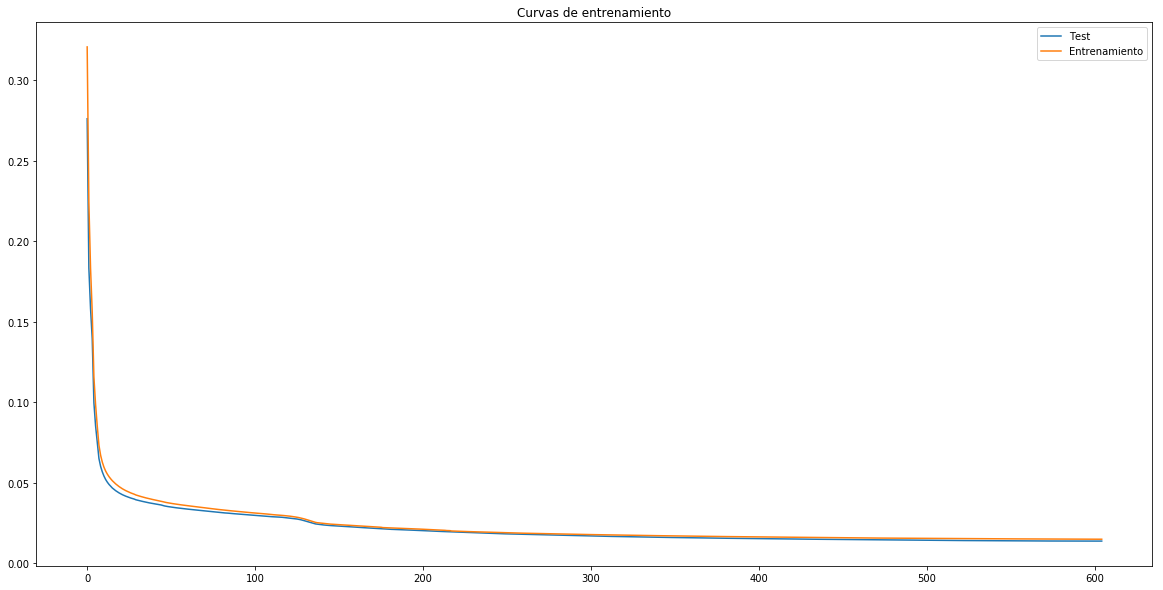

In [12]:
plt.figure(figsize=(20,10))
plt.title('Curvas de entrenamiento')
plt.plot(perdida_test_vector[:epoch])
plt.plot(perdida_train_vector[:epoch])
plt.legend( ('Test', 'Entrenamiento'), loc = 'upper right')
plt.show()

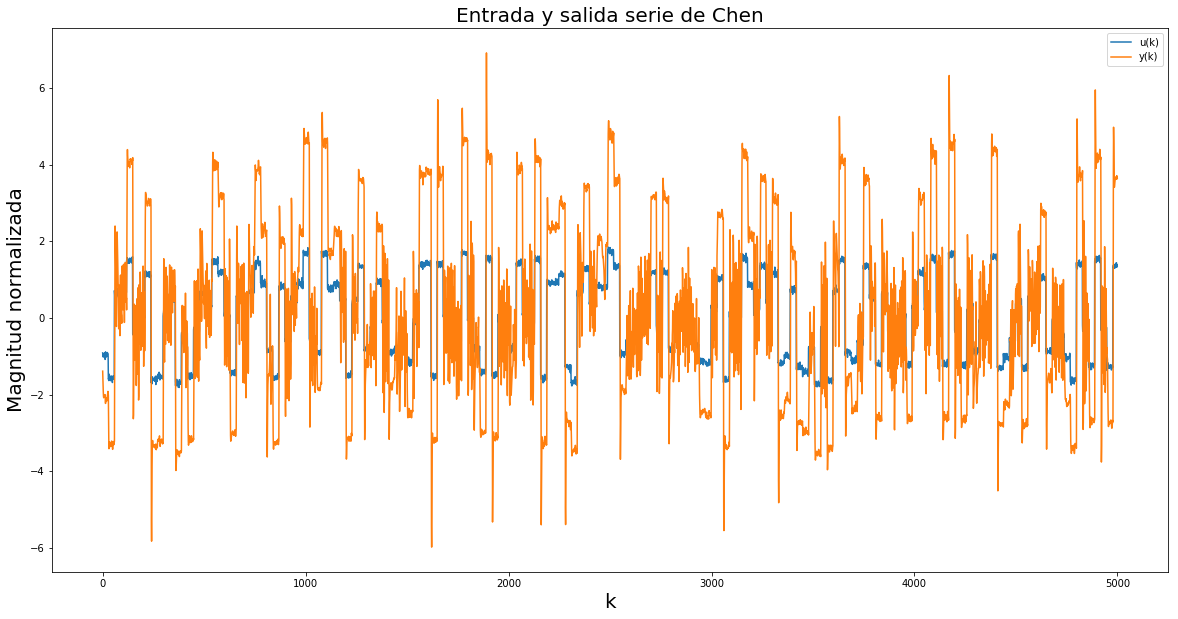

In [75]:
#######                     IMPORTAR LIBRERIAS                                          #######
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)



dataframe = pd.read_csv("datos.csv", header=None, delimiter = ';')
dataset = dataframe.values
dataset = dataset.astype('float32')

######

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# u(t) es la primera columna de train
# y(t) es la segunda columna de train 

u_data = np.reshape(dataset[:,0],(-1,1))
y_data = np.reshape(dataset[:,1],(-1,1))


plt.figure(figsize=(20,10))
plt.plot(u_data[:5000]) 
plt.plot(y_data[:5000])

plt.xlabel('k',fontsize = 20)
plt.ylabel('Magnitud normalizada',fontsize = 20)
plt.title('Entrada y salida serie de Chen',fontsize = 20)
plt.legend(('u(k)','y(k)'), loc = 'upper right')
plt.show()


# normalizacion

u_min = np.amin(u_data)
u_max = np.amax(u_data)

y_min = np.amin(y_data)
y_max = np.amax(y_data)

u_data = (u_data - u_min)/(u_max-u_min)
y_data = (y_data - y_min)/(y_max-y_min)


# REORDENAR CONJUNTO 
datos_normalizados = np.concatenate((u_data, y_data), axis=1) 

train_size = int(len(dataset) * 0.55)
test_size = int(len(dataset)*0.25)

m_train = datos_normalizados[0:train_size,:]
m_test = datos_normalizados[train_size:(train_size+test_size),:]
m_val = datos_normalizados[(train_size+test_size):len(datos_normalizados),:]


datos_ordenados = np.array(series_to_supervised(datos_normalizados, n_in=3, n_out=1))



#desordenar datos
np.random.shuffle(datos_ordenados)


train_size = int(len(dataset) * 0.55)
test_size = int(len(dataset)*0.25)

train_data, test_val_data =datos_ordenados[0:train_size,:], datos_ordenados[train_size:(len(dataset)),:]




#desordenar datos
np.random.shuffle(train_data)

x_train = train_data[:,0:6]
y_train = train_data[:,7]

x_test = test_val_data[0:test_size,0:6]
y_test = test_val_data[0:test_size:,7]

x_val = test_val_data[test_size:len(test_val_data),0:6]
y_val = test_val_data[test_size:len(test_val_data),7]






In [76]:
y_train = np.reshape(y_train,(-1,1))
y_test =  np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))


In [77]:
y_train_intervalo = np.concatenate((y_train,y_train,y_train),axis = 1)
y_test_intervalo = np.concatenate((y_test,y_test,y_test),axis = 1)
y_val_intervalo = np.concatenate((y_val,y_val,y_val),axis = 1)

In [78]:
def generar_mini_batch(X , y, batch_indice, batch_tamano):
    inicio = batch_indice*batch_tamano
    fin = (batch_indice+1)*batch_tamano
    X_batch = X[inicio:fin,:]
    y_batch = y[inicio:fin,:]
    return X_batch, y_batch

In [79]:
## Calcular PINAW PICP
"""
Esta funcion permite calcular el valor del PINAW, PICP y RMSE de
las predicciones a n pasos.
x_val = datos [u(t),y(t)] con estos se forma la matriz de entrenamiento
y_max = maximo valor salida 
y_min = minimo valor de salida 
Estos son utilizados para desnormalizar las predicciones y calcular apropiadamente las metricas

z1 = Es el nodo de salida del grafo utilizado.
z1 contiene [y_lower,y_crisp,y_upper]



"""
def calcular_PINAW_PICP(n,x_val,y_max,y_min,z1):
    n_in = 3
    matriz_n_paso = np.array(series_to_supervised(x_val, n_in=3, n_out=n+1))
    matriz_n_paso = np.reshape(matriz_n_paso,((matriz_n_paso.shape[0]),n_in+(n+1),2))    
    for i in range(0,(n+1)):
        x = matriz_n_paso[:,0+i:n_in+i,:]
        x = np.reshape(x,(x.shape[0],n_in*2))
        prediccion_val = z1.eval(feed_dict={X: x})
        y_lower = prediccion_val[:,0]
        y_crisp = prediccion_val[:,1]
        y_upper = prediccion_val[:,2]        
        rmse = np.sqrt(mean_squared_error(y_crisp*(y_max-y_min)+y_min,
                                          matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min))
        A = PINAW(y_upper*(y_max-y_min)+y_min,y_lower*(y_max-y_min)+y_min,matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min)
        B = PICP(y_upper*(y_max-y_min)+y_min,y_lower*(y_max-y_min)+y_min,matriz_n_paso[:,n_in+i,1]*(y_max-y_min)+y_min)      
        matriz_n_paso[:,n_in+i,1]=y_crisp
        PINAW_percent = A*100
        PICP_percent = B*100
    return PINAW_percent,PICP_percent,rmse

In [82]:
batch_size = 100
n_batches = int(np.ceil(x_train.shape[0] / batch_size))
n_epochs = 8000
perdida_test_vector = np.zeros(n_epochs)
perdida_train_vector = np.zeros(n_epochs)


# crear grafo
for lam in range(300,400,1):
    g,X,y,z1,training_op,init,saver,loss = red_neuronal(lam)

    with tf.Session(graph=g) as sess:
        sess.run(init)
        loss_minimo = 1000.0
        contador = 0
        for epoch in range(n_epochs):
            for batch_indice in range(n_batches):
                X_batch, y_batch = generar_mini_batch(x_train, y_train_intervalo, batch_indice, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

            perdida = sess.run(loss, feed_dict={X: x_test, y: y_test_intervalo})
            perdida_train = sess.run(loss, feed_dict={X: x_train, y: y_train_intervalo})


            #print('EPOCH: ',epoch,'LOSS_TEST: ',perdida)
            # early stopping
            if perdida < loss_minimo:
                loss_minimo = perdida
                #save_path = saver.save(sess, "./mejor_modelo.ckpt")
                contador = 0 # reiniciar contador


            else:
                contador +=1
                if contador == 10:

                    #print('El entrenamiento ha sido detenido')
                    break 

        PINAW_percent,PICP_percent,rmse = calcular_PINAW_PICP(1,m_test,y_max,y_min,z1)
        print('Red con parametro:' ,lam,'PINAW: ',PINAW_percent,'PICP: ',PICP_percent,'RMSE: ',rmse)
        if PICP_percent > 90.0:
                print(lam)
                best_PINAW = PINAW_percent
                save_path = saver.save(sess, "./my_model_intervalo1.ckpt")
                print('Ya se ha logrado el requisito de PICP > 90')


                break
    

Red con parametro: 300 PINAW:  18.0657129138 PICP:  74.46893787575151 RMSE:  0.635147
Red con parametro: 301 PINAW:  20.1169041261 PICP:  83.36673346693387 RMSE:  0.691827
Red con parametro: 302 PINAW:  14.5186172026 PICP:  81.96392785571143 RMSE:  0.694118
Red con parametro: 303 PINAW:  18.4648521232 PICP:  86.05210420841684 RMSE:  0.672557
Red con parametro: 304 PINAW:  16.2798411506 PICP:  82.36472945891784 RMSE:  0.652939
Red con parametro: 305 PINAW:  12.1387872476 PICP:  67.77555110220442 RMSE:  0.616152
Red con parametro: 306 PINAW:  20.9455680542 PICP:  90.5811623246493 RMSE:  0.666082
306
Ya se ha logrado el requisito de PICP > 90


## Parte 2

Se ha logrado el requisio con 306

In [84]:
best_PINAW = 100
for lam in range(0,100):
    g,X,y,z1,training_op,init,saver,loss = red_neuronal(306)

    with tf.Session(graph=g) as sess:
        sess.run(init)
        loss_minimo = 1000.0
        contador = 0
        for epoch in range(n_epochs):
            for batch_indice in range(n_batches):
                X_batch, y_batch = generar_mini_batch(x_train, y_train_intervalo, batch_indice, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

            perdida = sess.run(loss, feed_dict={X: x_test, y: y_test_intervalo})
            perdida_train = sess.run(loss, feed_dict={X: x_train, y: y_train_intervalo})


            #print('EPOCH: ',epoch,'LOSS_TEST: ',perdida)
            # early stopping
            if perdida < loss_minimo:
                loss_minimo = perdida
                #save_path = saver.save(sess, "./mejor_modelo.ckpt")
                contador = 0 # reiniciar contador


            else:
                contador +=1
                if contador == 10:

                    #print('El entrenamiento ha sido detenido')
                    break 

        PINAW_percent,PICP_percent,rmse = calcular_PINAW_PICP(1,m_test,y_max,y_min,z1)
        print('Iteración:' ,lam,'PINAW test: ',PINAW_percent,'PICP test: ',PICP_percent,'RMSE test: ',rmse)
        if PICP_percent > 90.0 and PINAW_percent < best_PINAW:
                
                best_PINAW = PINAW_percent
                #save_path = saver.save(sess, "./my_model_intervalo1.ckpt")
                print('Se ha logrado disminuir el PINAW')
                PINAW_percent_val,PICP_percent_val,rmse_val = calcular_PINAW_PICP(1,m_val,y_max,y_min,z1)
                print('PINAW val: ',PINAW_percent_val,'PICP val: ',PICP_percent_val,'RMSE val: ',rmse_val)

Iteración: 0 PINAW test:  18.9548562666 PICP test:  94.82965931863727 RMSE test:  0.58087
Se ha logrado disminuir el PINAW
PINAW val:  17.6663403255 PICP val:  92.98948422633951 RMSE val:  0.64692
Iteración: 1 PINAW test:  19.6075099094 PICP test:  86.0120240480962 RMSE test:  0.666153
Iteración: 2 PINAW test:  14.8214580557 PICP test:  90.90180360721443 RMSE test:  0.548883
Se ha logrado disminuir el PINAW
PINAW val:  14.38476821 PICP val:  87.58137205808713 RMSE val:  0.617677
Iteración: 3 PINAW test:  20.285539446 PICP test:  84.28857715430863 RMSE test:  0.753021
Iteración: 4 PINAW test:  16.841070217 PICP test:  91.66332665330661 RMSE test:  0.589267
Iteración: 5 PINAW test:  71.2505398612 PICP test:  90.82164328657315 RMSE test:  2.38218
Iteración: 6 PINAW test:  19.3527494111 PICP test:  84.3687374749499 RMSE test:  0.645381
Iteración: 7 PINAW test:  19.9394576063 PICP test:  85.69138276553106 RMSE test:  0.678608
Iteración: 8 PINAW test:  14.5356129478 PICP test:  88.5370741482

Iteración: 87 PINAW test:  19.9805415242 PICP test:  88.37675350701403 RMSE test:  0.667904
Iteración: 88 PINAW test:  21.7637672107 PICP test:  86.09218436873748 RMSE test:  0.708426
Iteración: 89 PINAW test:  16.0990059863 PICP test:  76.99398797595191 RMSE test:  0.731717
Iteración: 90 PINAW test:  71.4660801055 PICP test:  91.78356713426854 RMSE test:  2.36675
Iteración: 91 PINAW test:  13.2712609891 PICP test:  91.70340681362725 RMSE test:  0.530413
Iteración: 92 PINAW test:  17.5526583815 PICP test:  76.23246492985972 RMSE test:  0.70273
Iteración: 93 PINAW test:  12.8750685057 PICP test:  81.40280561122243 RMSE test:  0.625006
Iteración: 94 PINAW test:  19.9458907784 PICP test:  86.8937875751503 RMSE test:  0.675459
Iteración: 95 PINAW test:  71.5027665736 PICP test:  91.9438877755511 RMSE test:  2.37252
Iteración: 96 PINAW test:  12.9246321848 PICP test:  67.45490981963927 RMSE test:  0.503549
Iteración: 97 PINAW test:  19.1872672874 PICP test:  82.68537074148297 RMSE test:  0.

In [67]:
x_val.shape

(1998, 6)

In [68]:
x_test.shape

(2499, 6)

In [69]:
x_train.shape

(5498, 6)

In [70]:
test_val_data.shape

(4497, 8)